# Hamiltonian-based mixflows

Here we develop the code for dealing with continuous data
via mixflows using deterministic Hamiltonian dynamics.

In [1]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams["figure.figsize"]=15,7.5
plt.rcParams.update({'font.size': 24})

In [127]:
def flow(x,rho,u,steps,L,eps,gradlogp,momentum='laplace',direction='fwd',xi=np.pi/16):
    if steps==0: return x,rho,u,np.zeros(x.shape[1])
    
    # define laplace functions
    if momentum=='laplace':
        logm = lambda rho : laplace_logm(rho)
        gradlogm = lambda rho : laplace_gradlogm(rho)
        Fm = lambda rho : laplace_Fm(rho)
        Qm = lambda p : laplace_Qm(p)
        
    ljs=np.zeros(x.shape[1])
    for t in range(steps):
        if direction=='fwd': x,rho,u,tljs=T_Leps_fwd(x,rho,u,L,eps,gradlogp,logm,gradlogm,Fm,xi)
        if direction=='bwd': x,rho,u,tljs=T_Leps_bwd(x,rho,u,L,eps,gradlogp,logm,gradlogm,Fm,xi)
        ljs+=tljs
    # end for
    return x,rho,u,ljs
    

def T_Leps_fwd(x,rho,u,L,eps,gradlogp,logm,gradlogm,Fm,xi=np.pi/16):
    x,rho=Hamiltonian_update(x,rho,L,eps,gradlogp,gradlogm)
    u=(u+xi)%1
    J=logm(rho)
    rho=Qm((Fm(rho)+prz(x,u))%1)
    return x,rho,u,J/logm(rho)

def T_Leps_bwd(x,rho,u,L,eps,gradlogp,logm,gradlogm,Fm,xi=np.pi/16):
    J=logm(rho)
    rho=Qm((Fm(rho)-prz(x,u))&1)
    u=(u-xi)%1
    x,rho=Hamiltonian_update(x,rho,L,-eps,gradlogp,gradlogm)
    return x,rho,u,J/logm(rho)

def Hamiltonian_update(x,rho,L,eps,gradlogp,gradlogm):
    for l in range(L):
        rho+=eps*gradlogp(x)/2
        x  -=eps*gradlogm(rho)
        rho+=eps*gradlogp(x)/2
    # end for
    return x,rho
    
    
def prz(x,u): return 0.5*np.sin(2*x+u[np.newaxis,:])+0.5
def laplace_logm(rho): return -np.sum(np.abs(rho),axis=0)-np.log(2)
def laplace_gradlogm(rho): return -np.sign(rho)
def laplace_Fm(rho): return -0.5*np.sign(rho)*np.exp(-np.sign(rho)*rho)+0.5+0.5*np.sign(rho)
def laplace_Qm(p): return -np.sign(p-0.5)*np.log1p(-2*np.abs(p-0.5))

In [138]:
# define the target density and score
def logp(x): return -0.5*np.sum(x**2,axis=0)-x.shape[0]*np.log(2*np.pi)/2
def gradlogp(x): return x

M=1
d=1000
x=np.random.randn(M,d)
rho=np.random.randn(M,d)
u=np.random.rand(d)

In [139]:
steps=1000
L=100
eps=0.001
tx,trho,tu,tljs=flow(x,rho,u,steps,L,eps,gradlogp,momentum='laplace',direction='fwd',xi=np.pi/16)

(array([ 2.,  5.,  7.,  7., 35., 29., 28., 64., 38., 39., 47., 45., 32.,
        57., 40., 43., 43., 53., 55., 62., 36., 59., 47., 20., 53., 33.,
         8.,  8.,  3.,  2.]),
 array([-33.80340841, -31.67977318, -29.55613795, -27.43250273,
        -25.3088675 , -23.18523228, -21.06159705, -18.93796182,
        -16.8143266 , -14.69069137, -12.56705615, -10.44342092,
         -8.31978569,  -6.19615047,  -4.07251524,  -1.94888002,
          0.17475521,   2.29839044,   4.42202566,   6.54566089,
          8.66929611,  10.79293134,  12.91656657,  15.04020179,
         17.16383702,  19.28747224,  21.41110747,  23.5347427 ,
         25.65837792,  27.78201315,  29.90564837]),
 <BarContainer object of 30 artists>)

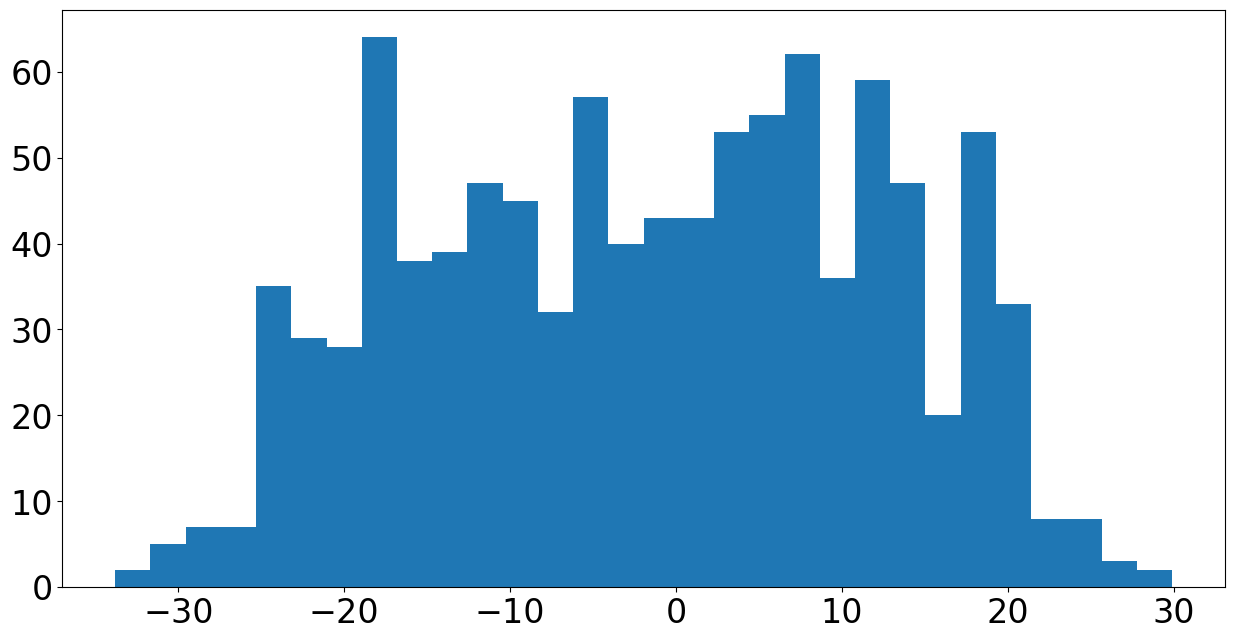

In [140]:
plt.hist(tx[0,:],bins=30)